In [19]:
import matplotlib.pyplot as plt
import pylab
import math
import numpy as np
import scipy
import scipy.linalg as la
# from numpy import linalg as LA
# from numpy.linalg import inv
import cmath
from scipy import special
from scipy import integrate
from scipy import interpolate
from numpy.polynomial.hermite import hermval
from sympy import Matrix
from numba import jit
from scipy.stats import linregress

In [95]:
num_points = 4000
# n = 0


# this value creates the dimensions of the expansion matrix. Atleast 70 for v = 20
expansion_number=110


# now respresents the max H.O. to be used in the expansion matrix
# these values will be used to calculate the max and min turning point and are necessary for capturing the full H.O. 
# wavefunction

n_max_gs = expansion_number
n_max_ex = expansion_number

#hartree energy unit
D_gs = 0.475217 #2.071824545e-18 J
D_ex = 0.20149  #8.78444853e-19 J

#bohr^-1 units
alpha_gs = 1.17199002 #6.20190409869e-11 meters^-1
alpha_ex = 1.23719524 #6.54695526318e-11 meters^-1

#bohr units'
shift = 0.201444790427

#mass in a.u.
mu = 12178.1624678

'frequency in a.u.'
omega_gs = 0.01599479871665311 #6.61246943e14 Hz
omega_ex = 0.01099445915946515
# omega_gs = 0.010353662727838314 #4.28020304e14 rad (value when not divided by 2pi)

'Hartree units'
E_adiabatic =0.0734987


Ha_to_eV=27.211396132


In [21]:
# nbound_gs=int((2.0*D_gs-omega_gs)/omega_gs)
# print(nbound_gs)

# nbound_ex=int((2.0*D_ex-omega_ex)/omega_ex)
# print(nbound_ex)

In [96]:
def spring_const(alpha,D):
	return (alpha**2)*2*D

def mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu):
	omega_gs = np.sqrt(spring_const(alpha_gs,D_gs)/mu)/2*math.pi
	omega_ex = np.sqrt(spring_const(alpha_ex,D_ex)/mu)/2*math.pi
	return omega_gs,omega_ex

def compute_morse_eval_n(omega,D,n):
	return omega*(n+0.5)-(omega**2/(4.0*D)*(n+0.5)**2.0)

def compute_Harm_eval_n(omega,D,n):
	return omega*(n+0.5)

def find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift):
	freq_gs = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[0]
	freq_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]
	E_max_gs=compute_Harm_eval_n(freq_gs,D_gs,n_max_gs) # compute the energies for the highest energy morse 
	E_max_ex=compute_Harm_eval_n(freq_ex,D_ex,n_max_ex) # state considered
	# find the two classical turning points for the ground state PES
	point1_gs = math.sqrt(2*E_max_gs/spring_const(alpha_gs,D_gs))
	point2_gs = -math.sqrt(2*E_max_gs/spring_const(alpha_gs,D_gs))
	
	point1_ex = math.sqrt(2*E_max_ex/spring_const(alpha_ex,D_ex))+shift
	point2_ex = -math.sqrt(2*E_max_ex/spring_const(alpha_ex,D_ex))+shift

	# now find the smallest value and the largest value
	start_point=min(point1_gs,point2_gs)
	end_point=max(point1_ex,point2_ex)
	return start_point,end_point


start_point=find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift)[0]
end_point=find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift)[1]

#mode frequency of each oscillator
omega_gs = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[0]
omega_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]

#quantum turning points, established from 10% increase of classical tp's due to tunneling


start_point=start_point-start_point*0.1
end_point= end_point+end_point*0.1
step_x=(end_point-start_point)/num_points
x_range = np.arange(start_point,end_point,step_x)

In [24]:

def Harm_wavefunc(x_range,omega,mu,n,shift):
	wavefunc=np.zeros((num_points,2))
	r_val=x_range*(math.sqrt(mu*omega))
	r_shift_val=shift*(math.sqrt(mu*omega))
	herm_coeffs = np.zeros(n+1)
	herm_coeffs[n] = 1
	norm=1/math.sqrt((2**n)*math.factorial(n))*(mu*omega/math.pi)**(0.25)
	#renormalize to prevent error buildup
	counter = 0.0
	for i in range(num_points):
		wavefunc[i,0]=start_point+counter*step_x
		counter = counter+1
	wavefunc[:,1] = norm*np.exp(-((r_val-r_shift_val)**2)/2)*np.polynomial.hermite.hermval(r_val-r_shift_val,herm_coeffs)
	psi_norm = integrate.simps(wavefunc[:,1]**2,dx=step_x)
	wavefunc[:,1] = wavefunc[:,1]/math.sqrt(psi_norm)
	
	return wavefunc


In [25]:

def H_e_on_gs_wavefunc(wavefunc,D,alpha,shift,mu,E_adiabatic):
    # first interpolate the wavefunction as a spline. Then compute derivative
    spl=interpolate.UnivariateSpline(wavefunc[:,0],wavefunc[:,1],s=0,k=4)
    second_deriv=spl.derivative(n=2)
    # calculate the 2nd derivative data only at the finite number of x values. 
    second_deriv_dat=second_deriv(wavefunc[:,0])
    op_wavefunc=np.zeros((wavefunc.shape[0],2))
    op_wavefunc[:,0]=wavefunc[:,0]
    op_wavefunc[:,1]=-1.0/(2.0*mu)*second_deriv_dat[:]
    for i in range(op_wavefunc.shape[0]):
        op_wavefunc[i,1]=op_wavefunc[i,1]+(D*(1.0-np.exp(-alpha*(op_wavefunc[i,0]-shift)))**2.0)*wavefunc[i,1]

    return op_wavefunc

def gs_wavefunc_He_matrix(num_points,omega,start_point,end_point,D,alpha,shift,mu,E_adiabatic,max_n_gs):
    overlap_matrix=np.zeros((max_n_gs,max_n_gs),dtype=np.complex_)
    final_overlap_matrix = np.zeros((max_n_gs,max_n_gs))   
    for i in range(max_n_gs):
        func1 = Harm_wavefunc(x_range,omega,mu,i,shift)       
        He_func1=H_e_on_gs_wavefunc(func1,D,alpha,shift,mu,E_adiabatic)
        for j in range(max_n_gs):
            func2 = Harm_wavefunc(x_range,omega,mu,j,shift)
            eff_func = func2[:,1]*He_func1[:,1]
            overlap_matrix[i,j] = integrate.simps(eff_func,dx=func2[1,0]-func2[0,0])
            overlap_matrix[j,i]=overlap_matrix[i,j]
    return overlap_matrix

In [28]:
def Morse_wavefunc(num_points,start_point,end_point,D,alpha,mu,n,shift):
        # first start by filling array with position points:
        wavefunc=np.zeros((num_points,2))
        lamda=math.sqrt(2.0*D*mu)/(alpha)
        step_x=(end_point-start_point)/num_points
        denom=special.gamma(2.0*lamda-n)
        if np.isinf(denom):
                denom=10e280
        num=(math.factorial(n)*(2.0*lamda-2.0*n-1.0))
        normalization=math.sqrt(num/denom)
        counter=0
        for x in wavefunc:
                x[0]=start_point+counter*step_x
                r_val=(start_point+counter*step_x)*alpha
                r_shift_val=(shift)*alpha
                z_val=2.0*lamda*math.exp(-(r_val-r_shift_val))
                func_val=normalization*z_val**(lamda-n-0.5)*math.exp(-0.5*z_val)*special.assoc_laguerre(z_val,n,2.0*lamda-2.0*n-1.0)
                x[1]=func_val
                counter=counter+1

	# fix normalization regardless of value of denominator to avoid rounding errors
        wavefunc_sq=np.zeros(wavefunc.shape[0])
        wavefunc_sq[:]=wavefunc[:,1]*wavefunc[:,1]
        normalization=integrate.simps(wavefunc_sq,dx=step_x)
        for counter in range(wavefunc.shape[0]):
                wavefunc[counter,1]=wavefunc[counter,1]/math.sqrt(normalization)

        return wavefunc

In [97]:
overlaps = gs_wavefunc_He_matrix(num_points,omega_gs,start_point,end_point,D_gs,alpha_gs,0.0,mu,0.0,expansion_number)


def Linear_combo_wfs(x_range,omega,D,alpha,mu,expansion_number,shift,overlaps):
#     EIG,COEF = LA.eigh(overlaps,UPLO='U')
    EIG, COEF = la.eigh(overlaps)
#     eigenvec = np.asarray(results[1])
    LC_func = np.zeros((num_points,expansion_number,expansion_number))
    LC_func_final = np.zeros((num_points,expansion_number+1))
    for i in range (expansion_number):
        for j in range (expansion_number):
            LC_func[:,i,j] = Harm_wavefunc(x_range,omega,mu,j,shift)[:,1]*COEF[j,i]
    
    LC_func_final[:,0] = x_range
    LC_func_final[:,1:] = LC_func.sum(axis=2)
    for i in range(expansion_number):
        integration_val = integrate.simps(LC_func_final[:,i+1])
        if integration_val<0:
            LC_func_final[:,i+1] = LC_func_final[:,i+1]*-1
        else:
            LC_func_final[:,i+1] = LC_func_final[:,i+1]

    return LC_func_final



In [98]:
Morse_appx = Linear_combo_wfs(x_range,omega_gs,D_gs,alpha_gs,mu,expansion_number,0.0,overlaps)

C:\Users\vagui\anaconda3\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


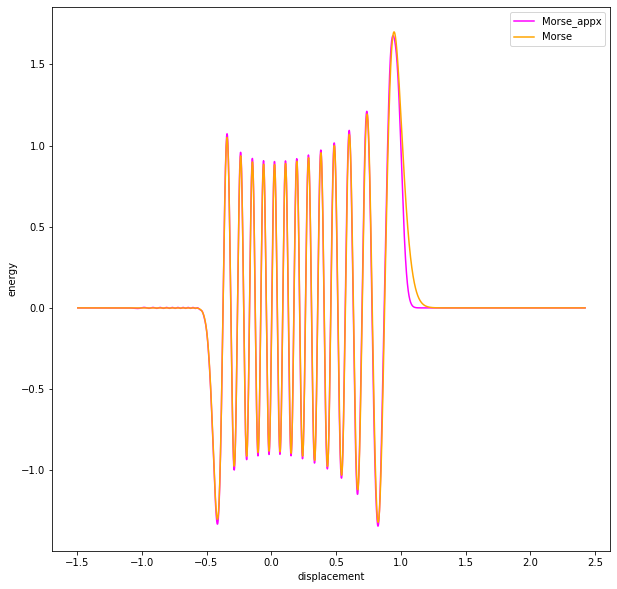

In [99]:
wavefunc = Harm_wavefunc(x_range,omega_gs,mu,110,0.0)
Morse_exact = Morse_wavefunc(num_points,start_point,end_point,D_gs,alpha_gs,mu,25,0.0)



fig,ax = plt.subplots(figsize=(10,10))

x = Morse_appx[:,0]
y = Morse_appx[:,26]

x1 = wavefunc[:,0]
y1 = wavefunc[:,1]

x2 = Morse_exact[:,0]
y2 = Morse_exact[:,1]


line1 = ax.plot(x,y,color='magenta',label='Morse_appx')
# line2 = ax.plot(x1,y1,color='blue',label='Harm')
line2 = ax.plot(x2,y2,color='orange',label='Morse')
ax.legend()
ax.set_xlabel('displacement')
ax.set_ylabel('energy')
plt.show()

# print('coefficients:',coefficients)
# print('coefficients sum SQ:',sum(coefficients**2))
# print('')


 **expansion_number = 50**
 
 0,1 -normal; 2,3,4,5 -flipped; 6,7,8 -normal; 9 -flipped; 10,11 -normal; 12,13,14, -flipped; 15 -normal ( start losing correlation); 16 -flipped; 17,18 -normal; 19,20 -flipped

 **expansion_number = 60**

0,1 -normal; 2,3,4,5 -flipped; 6,7 -normal; 8,9 -flipped; 10,11 -normal; 12,13, -flipped; 14,15 -normal ; 16,17 ( start losing correlation)-flipped; 18 -normal; 19,20 -flipped;


**Changing boundaries for Harmonic expansion**

max gs states = 57

max ex states = 35

In [43]:
for i in range(expansion_number):
    integration_value = integrate.simps(Morse_appx[:,i],dx=Morse_appx[1,0]-Morse_appx[0,0])
    print(integration_value)


1.2618464525633648
0.5630200039552993
0.041895988371335235
-0.40144508736338125
-0.05203323809003964
-0.3506467452708112
-0.05900970896495004
-0.3229183227412744
0.06467178360649191
-0.3048005755411305
0.06962181569446868
0.2918550157452858
-0.07413760309135718
0.2821109599160011
-0.07837284569785598
0.27453494955136887
0.08242204475833659
-0.26851842394958714
-0.08632649956936173
-0.26359050801483946
-0.08980374048267246
-0.25844381551935525
0.08974972492685106
-0.24573362605459564
0.07157548842728519
0.21057135355786266
-0.027308550005311794
0.1678544748609794
-0.011619856112719302
-0.14055420976112057
0.03375431212123261
0.12566434044246125
-0.04594258776087344
-0.11689197091870177
-0.05320430836145573
-0.11109900623772215
0.05787539841786526
-0.10689410509019197
-0.061053269443531656
0.10362094081481799
-0.0633004297716036
-0.10094108099937703
0.06493176562348615
-0.09866518357659324
0.06613706463746753
-0.09667980838043976
-0.0670377155214736
0.09491302654713618
-0.067715149730612